# Vehicle Identification project

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imutils
from sklearn.model_selection import train_test_split
from pathlib import Path
from sklearn.externals import joblib
import os
import glob
import time
%matplotlib inline

In [2]:
from FeatureExtractor import *

### Set parameters and extract image features

In [3]:
orient = 9  
pix_per_cell = 8 
cell_per_block = 2 
color_space = 'YUV' 
spatial_size = (32, 32) 
hist_bins = 32   
spatial_feat = True
hist_feat = True
hog_feat = True
y_start_stop = [500, None] 

In [4]:
def get_image(name):
    img = cv2.imread(name)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def get_features(name, visual=True):
    img = get_image(name)
    return get_image_features(img, visual=visual)

def get_image_features(img, visual=True):
    return FeatureExtractor.get_features(img, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)

In [5]:
vehicles = glob.glob('./project/vehicles/**/*.png', recursive=True)
non_vehicles = glob.glob('./project/non-vehicles/**/*.png', recursive=True)
print("Vehicle images: " + str(len(vehicles)))
print("Non vehicle images: " + str(len(non_vehicles)))

Vehicle images: 8792
Non vehicle images: 8968


In [6]:
vehicle_features = []
non_vehicle_features = []

for vehicle in vehicles:
    features = get_features(vehicle)
    vehicle_features.append(features)

for non_vehicle in non_vehicles:
    features = get_features(non_vehicle)
    non_vehicle_features.append(features)

feature_len = np.shape(vehicle_features)[-1]
vehicle_features = np.reshape(vehicle_features, (len(vehicles), feature_len))
non_vehicle_features = np.reshape(non_vehicle_features, (len(non_vehicles), feature_len))

print("Feature vectors have been created!")

/home/fabiovalerio/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Feature vectors have been created!


In [7]:
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

print("Fetures have been normalized!")

Fetures have been normalized!


### Test HOG feature extraction

/home/fabiovalerio/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


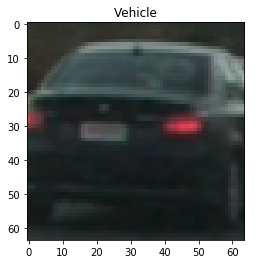

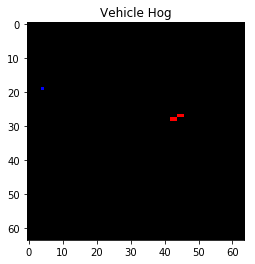

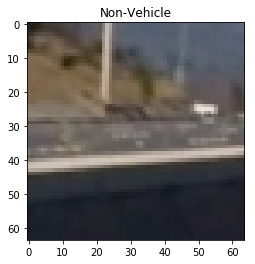

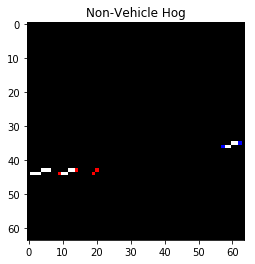

In [8]:
vehicle_img = get_image(vehicles[np.random.randint(len(vehicles))])
non_vehicle_img = get_image(non_vehicles[np.random.randint(len(non_vehicles))])
feature_vehicle, hog_img1 = FeatureExtractor.get_hog_features(vehicle_img, orient=orient, 
                                                              pix_per_cell=pix_per_cell,
                                                              cell_per_block=cell_per_block, 
                                                              vis=True)
feature_non_vehicle, hog_img2 = FeatureExtractor.get_hog_features(non_vehicle_img, orient=orient, 
                                                                  pix_per_cell=pix_per_cell, 
                                                                  cell_per_block=cell_per_block, 
                                                                  vis=True)
imgs = [vehicle_img, hog_img1*255, non_vehicle_img, hog_img2*255]

plt.figure()
plt.title("Vehicle")
plt.imshow(vehicle_img)
#plt.savefig("output_images/vehicle_image.jpg")

plt.figure()
plt.title("Vehicle Hog")
plt.imshow(hog_img1*255)
#plt.savefig("output_images/hog_vehicle_image.jpg")

plt.figure()
plt.title("Non-Vehicle")
plt.imshow(non_vehicle_img)
#plt.savefig("output_images/non_vehicle_image.jpg")

plt.figure()
plt.title("Non-Vehicle Hog")
plt.imshow(hog_img2*255)
#plt.savefig("output_images/hog_non_vehicle_image.jpg")

plt.show()

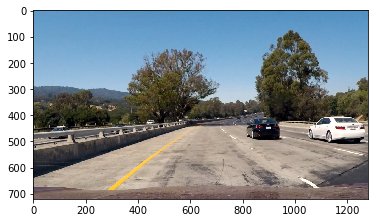

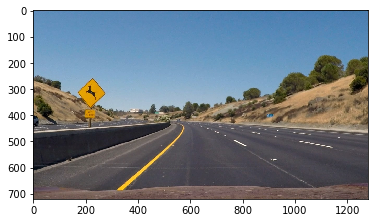

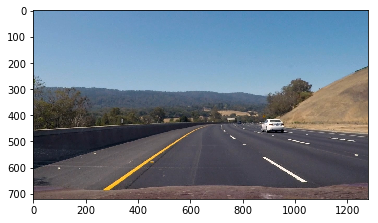

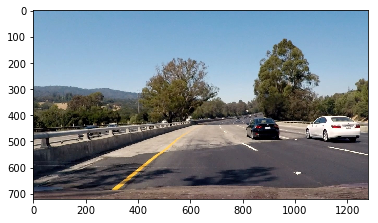

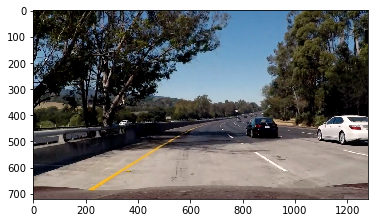

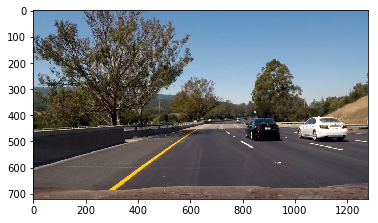

In [9]:
imgs = []
files = glob.glob('./test_images/*.jpg', recursive=True)
for image_name in files:
    img = get_image(image_name)
    imgs.append(img)
    plt.figure()
    plt.imshow(img)
plt.show()

### Select image ROI

In [10]:
def draw_rectangle(img, locations):
    color = (255, 0, 0)
    bboxes = locations
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, 6)
    return imcopy

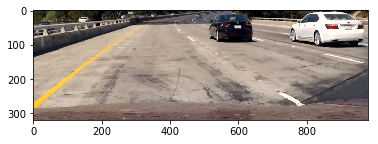

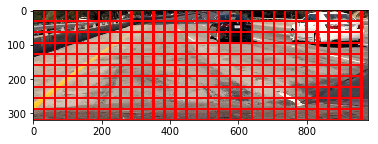

In [11]:
test_img = get_image("./test_images/test1.jpg")
roi_img = test_img[400:,300:,:]
plt.figure()
plt.imshow(roi_img)
#plt.savefig("output_images/sliding_window_original_image.jpg")

all_wins = FeatureExtractor.slide_window(roi_img)
rec_img = draw_rectangle(roi_img, all_wins)
plt.figure()
plt.imshow(rec_img)
#plt.savefig("output_images/sliding_window_grid_image.jpg")
plt.show()

### Train the classifier

In [12]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3)

In [13]:
svc = LinearSVC()
svc.fit(X_train, y_train)

print("Test Accuracy = {:.2f}".format(round(svc.score(X_test, y_test), 4)))

Test Accuracy = 0.99


## Pipeline definition

/home/fabiovalerio/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


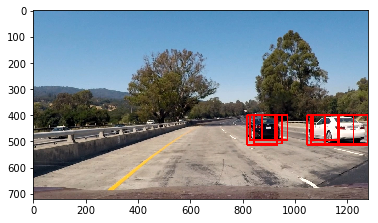

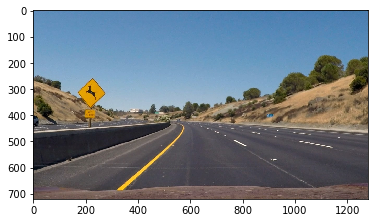

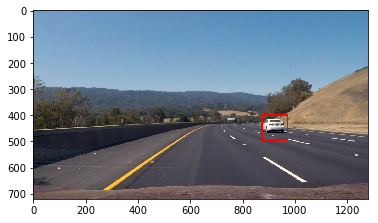

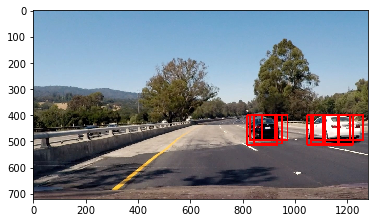

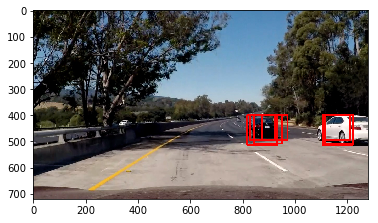

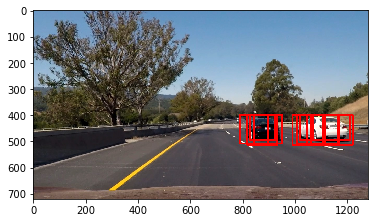

In [14]:
def scale_windows(windows, scale, x_start=300, y_start=400):
    res_wins = []
    for win in windows:
        res_wins.append(((x_start+int(win[0][0]*scale), y_start+int(win[0][1]*scale)), 
                         (x_start+int(win[1][0]*scale), y_start+int(win[1][1]*scale))))
    return res_wins

def find_windows(img, scale, xy_window=(96,96)):
    y,x, c = np.shape(img)
    x_start = int(300/scale)
    y_start = int(400/scale)
    tmp = img.copy()[y_start:, x_start:,:]
    windowss = FeatureExtractor.slide_window(tmp, x_start_stop=[None, None],
                                             y_start_stop=[None,None],xy_window=xy_window,
                                             xy_overlap=(0.5, 0.5))
    tmp = FeatureExtractor.search_windows(tmp, windowss, svc, X_scaler, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        hist_range=(0, 256), orient=9,
                        pix_per_cell=8, cell_per_block=2,
                        spatial_feat=True,
                        hist_feat=True, hog_feat=True)    
    return scale_windows(tmp, scale, 300,400)

for img in imgs:
    win = []
    for scale in [1.5,1.7,1.8]:
        w = int(img.shape[1] / scale)
        resized = imutils.resize(img, width=w)
        win0 = find_windows(resized, scale, xy_window=(64,64))
        win += win0
    rec_img = draw_rectangle(img, win)
    plt.figure()
    plt.imshow(rec_img)
    
plt.show()

/home/fabiovalerio/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


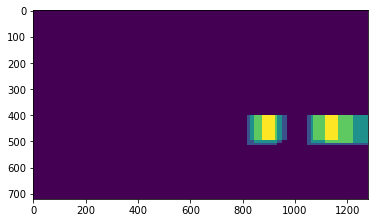

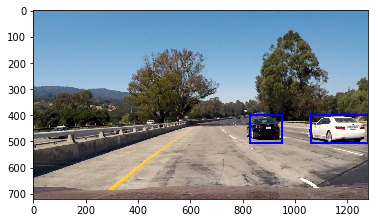

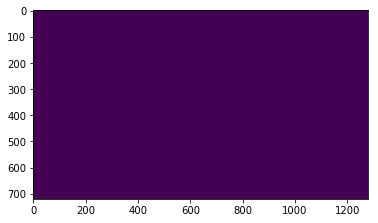

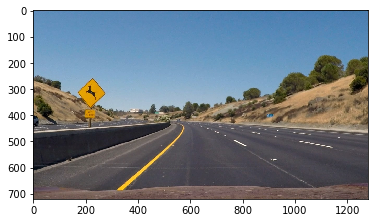

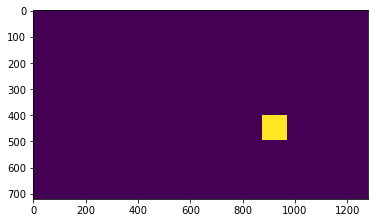

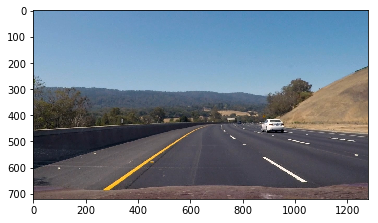

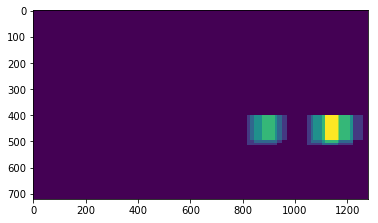

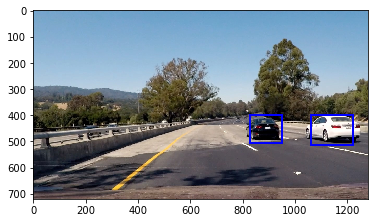

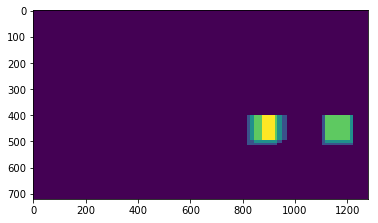

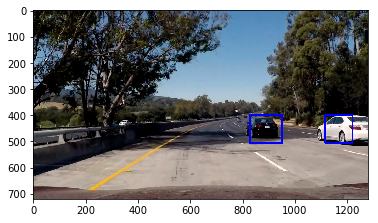

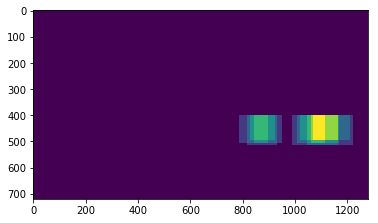

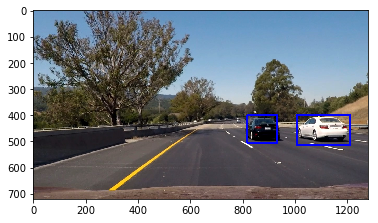

In [17]:
def pipeline(img, show_heatmap=False, false_negative=True):
    win = []
    t1 = time.time()
    for scale in [1.5,1.7,1.8]:
        w = int(img.shape[1] / scale)
        resized = imutils.resize(img, width=w)
        win0 = find_windows(resized, scale, xy_window=(64,64))
        win += win0
   
    heat_map = FeatureExtractor.add_heat(img, win)
    if show_heatmap==True:
        plt.figure()
        plt.imshow(heat_map)
        plt.show()
    
    if false_negative==True:
        heat_map = FeatureExtractor.apply_threshold(heat_map, threshold=1)
    
    labels = label(heat_map)
    return FeatureExtractor.draw_labeled_bboxes(img, labels)
        
for img in imgs:
    plt.figure()
    plt.imshow(pipeline(img, show_heatmap=True, false_negative=True))
plt.show()

### Workout video

In [20]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [23]:
white_output = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:45<00:01,  1.19s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 4min 29s, sys: 1.28 s, total: 4min 30s
Wall time: 46.6 s


In [24]:
%%HTML
<video width="640" height="480" controls>
  <source src="test_video_output.mp4" type="video/mp4">
</video>

In [31]:
white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [26:12<00:01,  1.20s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2h 29min 19s, sys: 46.2 s, total: 2h 30min 6s
Wall time: 26min 12s


In [32]:
%%HTML
<video width="640" height="480" controls>
  <source src="project_video_output.mp4" type="video/mp4">
</video>

### Average the result

In [18]:
heatmaps = []

def concatenate_heatmaps(heatmaps):
    hmap = heatmaps[0]
    for heatmap in heatmaps:
        hmap = np.logical_or(hmap, heatmap)
        
    return 1*hmap
        
def average_pipeline(img):
    win = []
    t1 = time.time()
    for scale in [1.5,1.7,1.8]:
        w = int(img.shape[1] / scale)
        resized = imutils.resize(img, width=w)
        win0 = find_windows(resized, scale, xy_window=(64,64))
        win += win0
    heat_map = FeatureExtractor.add_heat(img, win)
    heat_map = FeatureExtractor.apply_threshold(heat_map, threshold=1)
    
    heatmaps.append(heat_map)
    if len(heatmaps) > 20:
        heatmaps.pop(0)
        
    heat_map = concatenate_heatmaps(heatmaps)
    
    labels = label(heat_map)
    return FeatureExtractor.draw_labeled_bboxes(img, labels)

Applied average pipeline to test video.

In [21]:
white_output = 'test_video_output_ave.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_video_output_ave.mp4
[MoviePy] Writing video test_video_output_ave.mp4


 97%|█████████▋| 38/39 [00:45<00:01,  1.21s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output_ave.mp4 

CPU times: user 4min 26s, sys: 1.46 s, total: 4min 27s
Wall time: 46.6 s


In [22]:
%%HTML
<video width="640" height="480" controls>
  <source src="test_video_output_ave.mp4" type="video/mp4">
</video>

In [ ]:
white_output = 'project_video_output_ave.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(average_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output_ave.mp4
[MoviePy] Writing video project_video_output_ave.mp4


 85%|████████▌ | 1073/1261 [22:14<04:00,  1.28s/it]

In [ ]:
%%HTML
<video width="640" height="480" controls>
  <source src="project_video_output_ave.mp4" type="video/mp4">
</video>